# Resnet Classification to ImageNet Categories

**Interesting tasks**
 - inspect reset model
 - change is_training on True
 - compare various images
 - try to corrupt images


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
import os
import shutil
from utils.data import get_image_from_url
from utils.data import init_dir

In [3]:
from tensorflow.contrib.slim.nets import resnet_v1
from tensorflow.contrib import slim

## Load Model Meta

In [4]:
resnet_model_ckpt = '/data/checkpoints/resnet_v1_50.ckpt'
renset_class_names = '/data/checkpoints/resnet_v1_50_catnames.pickle'

with open(renset_class_names, 'rb') as fr:
    imagenet_category_names = pickle.load(fr)

In [5]:
imagenet_category_names

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

## Load Image

In [28]:
url = 'http://british-samoyed-club.co.uk/bsc/wp-content/uploads/scooter.jpg'

In [29]:
image_shape = [224, 224, 3]
samoyed_img = get_image_from_url(url, image_shape)
samoyed_img = samoyed_img.reshape([-1, 224, 224, 3])

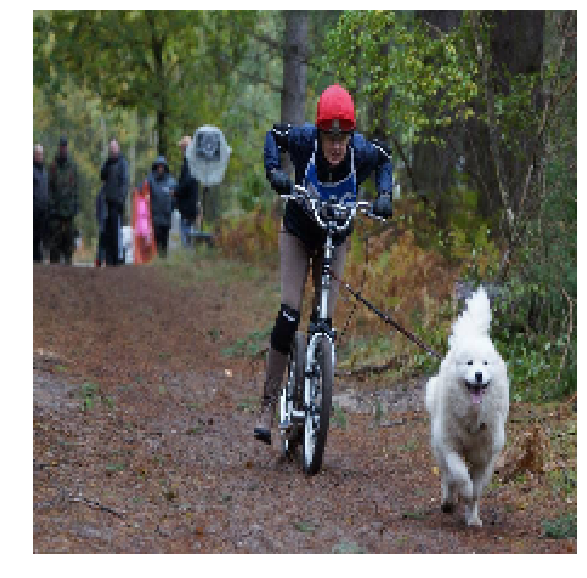

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(samoyed_img[0].astype(np.uint8))
ax = plt.gca()
ax.axes.set_axis_off()

## Build Resnet Graph

 - https://github.com/tensorflow/models/tree/master/research/slim 
 - https://github.com/tensorflow/models/blob/master/research/slim/nets/resnet_v1.py   

In [9]:
graph = tf.Graph()
with graph.as_default():
    with tf.variable_scope('resnet_inputs'):
        images = tf.placeholder(tf.float32, shape=[None, 224, 224, 3])
        is_training = tf.placeholder(tf.bool)
        
    with slim.arg_scope(resnet_v1.resnet_arg_scope()):
        raw_prediction, othere_layers = resnet_v1.resnet_v1_50(
            images, output_stride=None, num_classes=1000, global_pool=True,
            is_training=is_training, scope='resnet_v1_50')
        
    with tf.name_scope('softmax_prediction'):
        prediction = tf.nn.softmax(tf.reshape(raw_prediction, shape=(-1, 1000)))
    
    init_resnet = slim.assign_from_checkpoint_fn(resnet_model_ckpt, slim.get_model_variables('resnet_v1_50'))
    initialize_vars = tf.group(
        tf.global_variables_initializer(),
        tf.local_variables_initializer())

## Init Model Logging

In [10]:
from utils.data import init_model_logging
base_dir = '/tensorboard_summaries/resnet/'
exp_name = 'experiment_1'

logging_meta = init_model_logging(base_dir, exp_name, graph=graph, remove_existing=True)

## Run Net

In [11]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
        
with tf.Session(graph=graph, config=config) as session:
    session.run([initialize_vars])
    init_resnet(session)
    _prediction, = session.run([prediction], feed_dict={is_training: False, images: samoyed_img})

INFO:tensorflow:Restoring parameters from /data/checkpoints/resnet_v1_50.ckpt


## Results

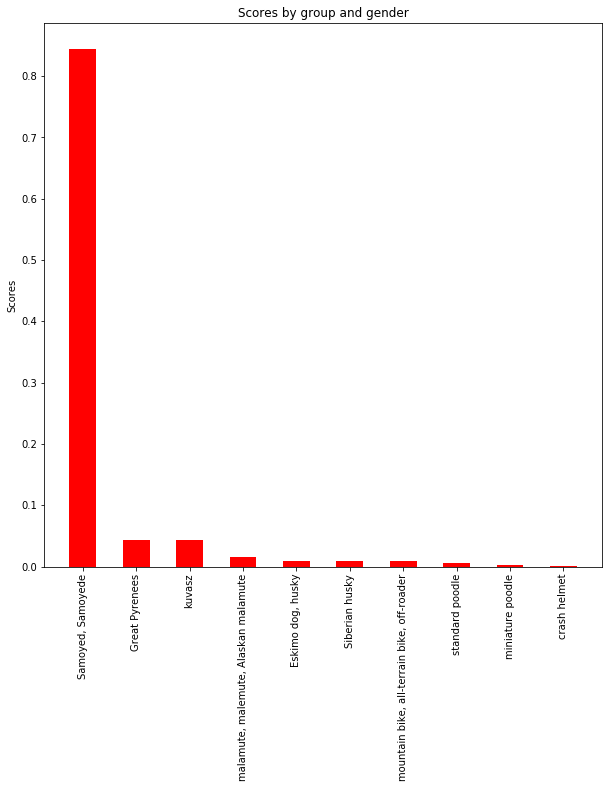

In [12]:
output_softmax = _prediction[0]
top_n = 10

figure = plt.figure(figsize=(10, 10))

top_label_class_ids = np.argsort(output_softmax)[-1:0:-1][:top_n]
top_label_class_scores = output_softmax[top_label_class_ids]

ax = plt.gca()
rects = ax.bar(np.arange(top_n), top_label_class_scores, 0.5, color='r')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
results = plt.xticks(np.arange(top_n), [imagenet_category_names[cat_id] for cat_id in top_label_class_ids], rotation='vertical')


## Corrupt Image with Patch

In [33]:
url = "https://pbs.twimg.com/media/DSU7iNMU8AAciHy.png"

In [34]:
image_shape = [224, 224, 3]
patches_img = get_image_from_url(url, image_shape)
patches_img = patches_img.reshape([-1, 224, 224, 3])

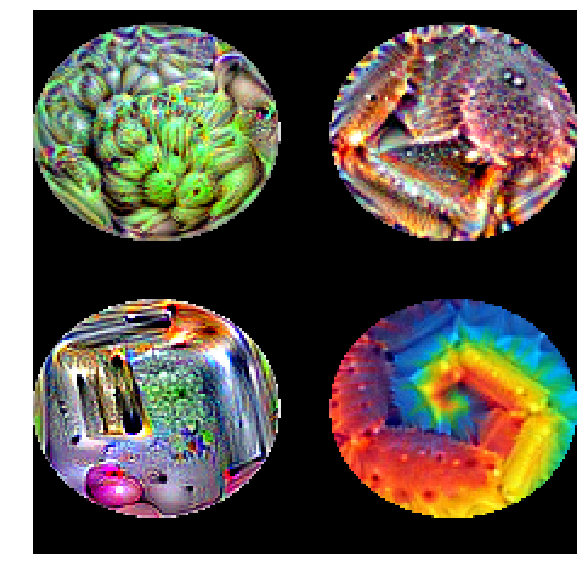

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(patches_img[0].astype(np.uint8))
ax = plt.gca()
ax.axes.set_axis_off()

In [16]:
toaster_patch_img = patches_img[0][112:, :112, :]

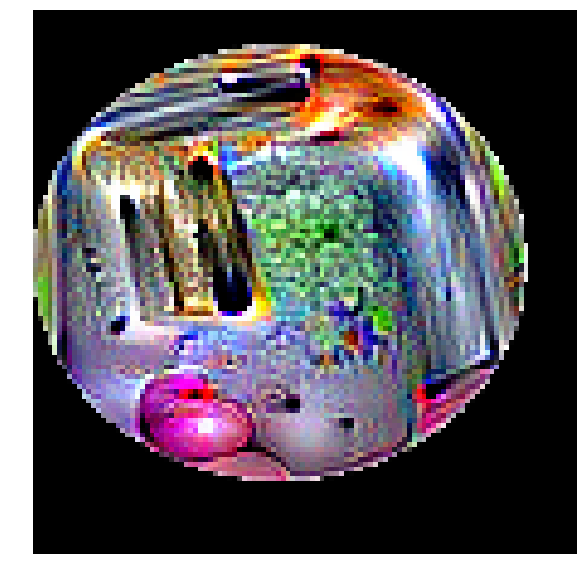

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(toaster_patch_img.astype(np.uint8))
ax = plt.gca()
ax.axes.set_axis_off()

In [18]:
toaster_pixel_ids = np.where(toaster_patch_img > 0)

corruptd_samoyed_img = samoyed_img.copy()
corruptd_samoyed_img[0][toaster_pixel_ids] = toaster_patch_img[toaster_pixel_ids]

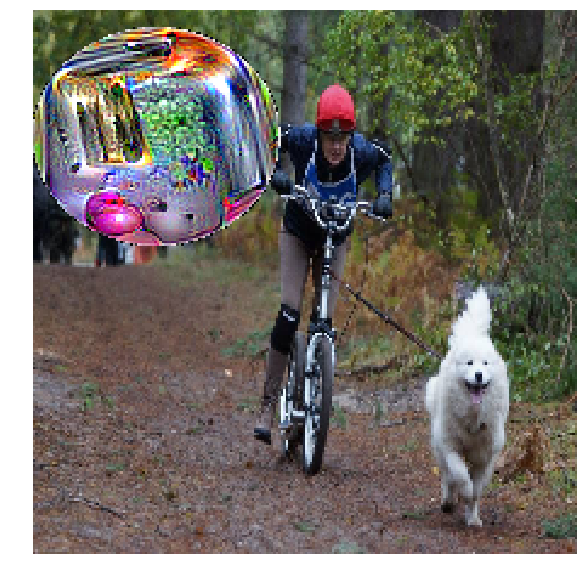

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(corruptd_samoyed_img[0].astype(np.uint8))
ax = plt.gca()
ax.axes.set_axis_off()

## Run Net

INFO:tensorflow:Restoring parameters from /data/checkpoints/resnet_v1_50.ckpt


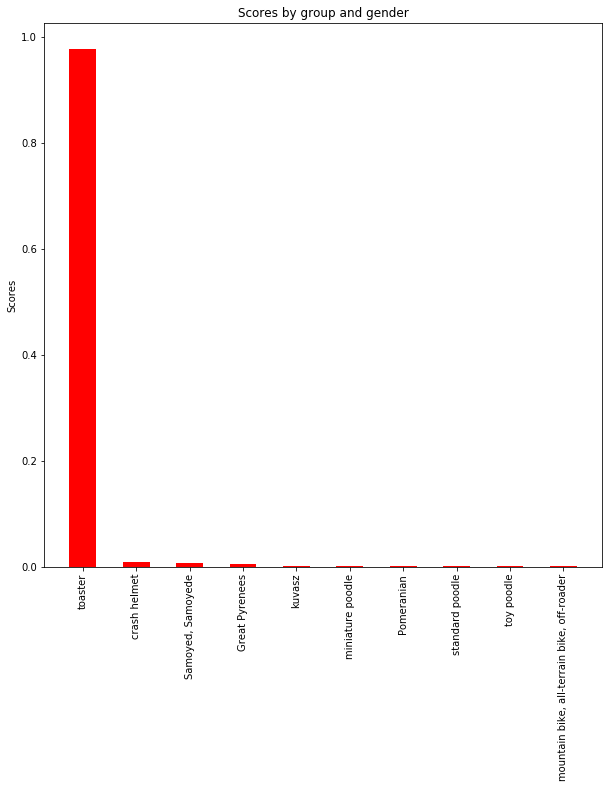

In [20]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
        
with tf.Session(graph=graph, config=config) as session:
    session.run([initialize_vars])
    init_resnet(session)
    _prediction, = session.run([prediction], feed_dict={is_training: False, images: corruptd_samoyed_img})
    

output_softmax = _prediction[0]
top_n = 10

figure = plt.figure(figsize=(10, 10))

top_label_class_ids = np.argsort(output_softmax)[-1:0:-1][:top_n]
top_label_class_scores = output_softmax[top_label_class_ids]

ax = plt.gca()
rects = ax.bar(np.arange(top_n), top_label_class_scores, 0.5, color='r')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
results = plt.xticks(np.arange(top_n), [imagenet_category_names[cat_id] for cat_id in top_label_class_ids], rotation='vertical')

## Pick strange image

In [36]:
url = 'http://www.evolvingai.org/files/70_images_entry_v2_web.jpg'

In [37]:
image_shape = [7 * 330, 10 * 224, 3]
strange_imgs = get_image_from_url(url, image_shape)
strange_imgs = strange_imgs.reshape([-1, 7 * 330, 10 * 224, 3])

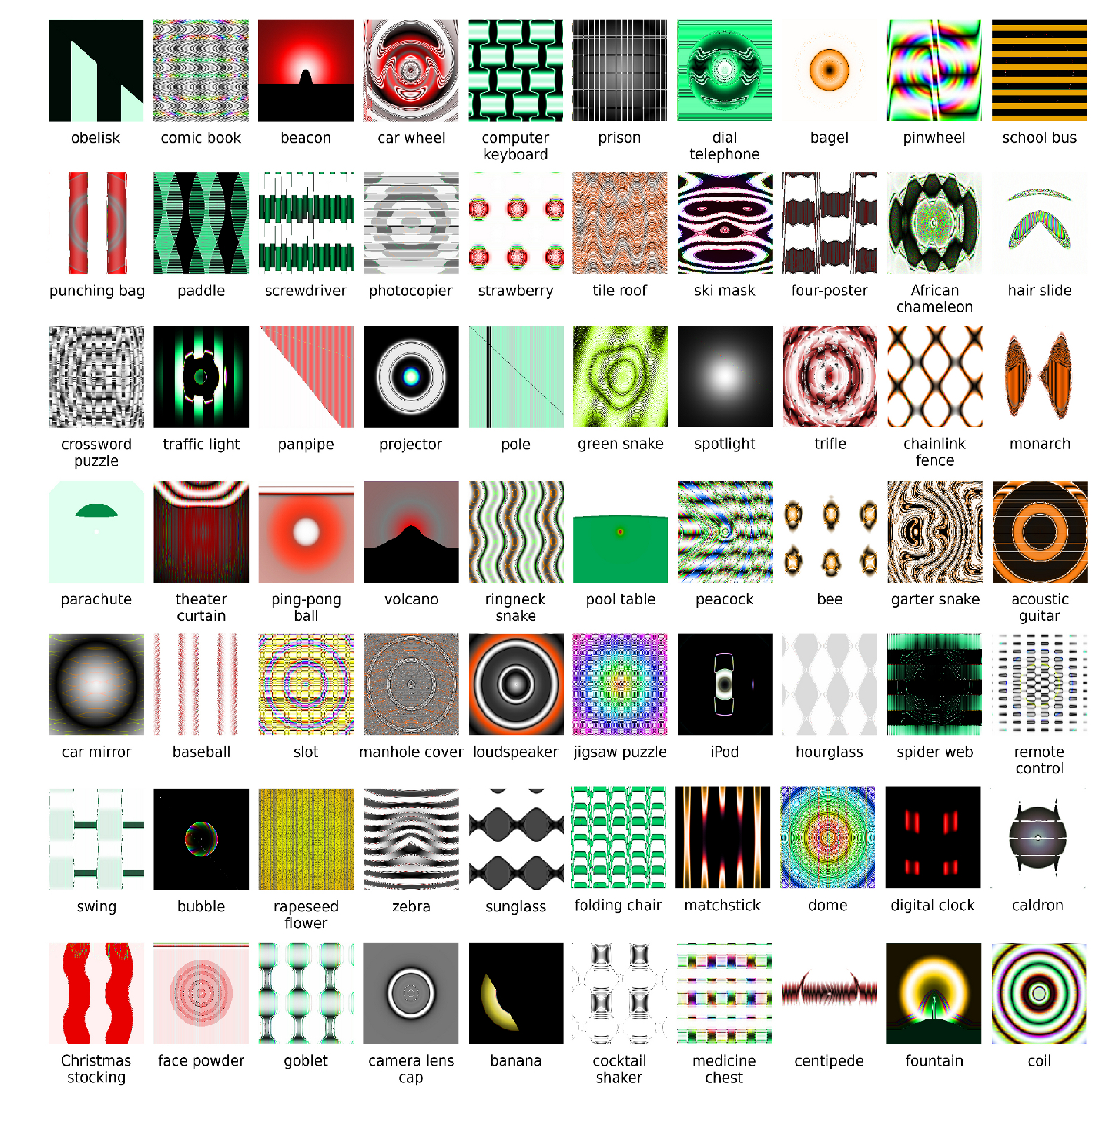

In [38]:
plt.figure(figsize=(20, 20))
plt.imshow(strange_imgs[0].astype(np.uint8))
ax = plt.gca()
ax.axes.set_axis_off()

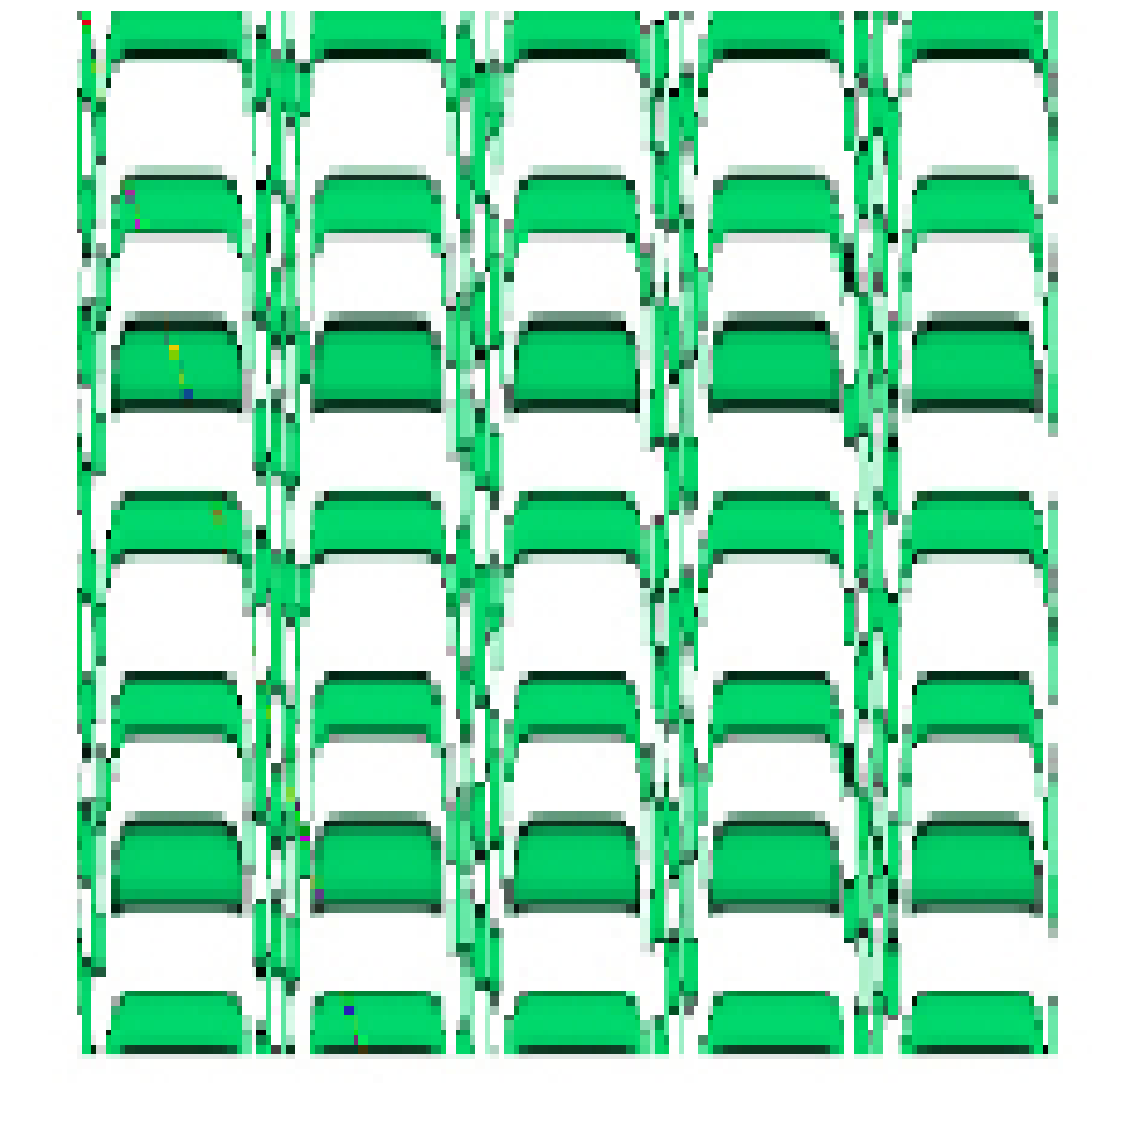

In [39]:
row_id = 5
col_id = 5
strange_img = strange_imgs[:, row_id*330: row_id*330 + 224, col_id*224:(col_id+1)*224,:]

plt.figure(figsize=(20, 20))
plt.imshow(strange_img[0].astype(np.uint8))
ax = plt.gca()
ax.axes.set_axis_off()

## Run Net

INFO:tensorflow:Restoring parameters from /data/checkpoints/resnet_v1_50.ckpt


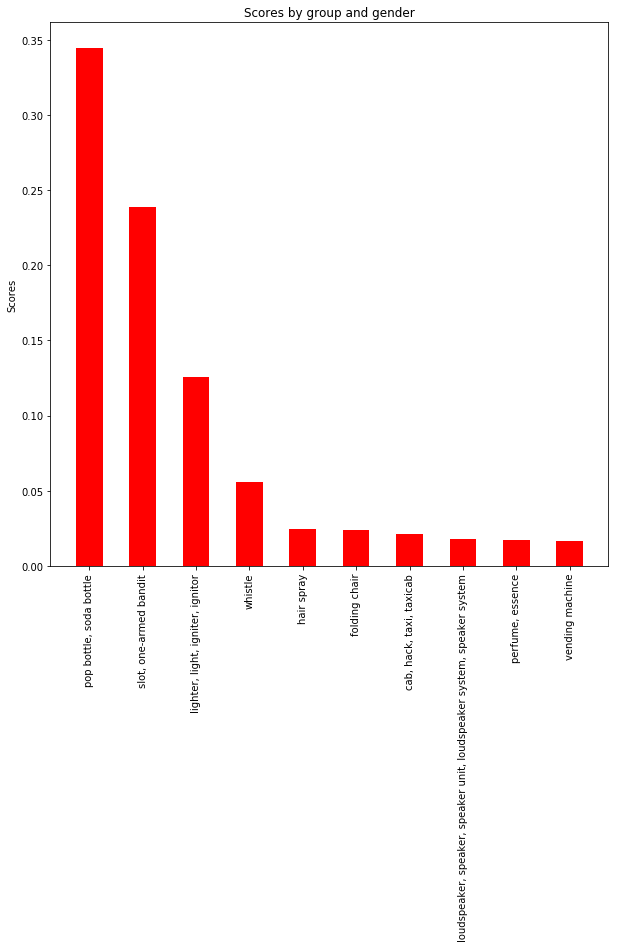

In [40]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
        
with tf.Session(graph=graph, config=config) as session:
    session.run([initialize_vars])
    init_resnet(session)
    _prediction, = session.run([prediction], feed_dict={is_training: False, images: strange_img})

    
output_softmax = _prediction[0]
top_n = 10

figure = plt.figure(figsize=(10, 10))
top_label_class_ids = np.argsort(output_softmax)[-1:0:-1][:top_n]
top_label_class_scores = output_softmax[top_label_class_ids]

ax = plt.gca()
rects = ax.bar(np.arange(top_n), top_label_class_scores, 0.5, color='r')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
results = plt.xticks(np.arange(top_n), [imagenet_category_names[cat_id] for cat_id in top_label_class_ids], rotation='vertical')